In [4]:
%matplotlib inline
import pandas as pd
import uproot
import awkward
import matplotlib.pyplot as plt
import numpy as np
import math
import numba
from matplotlib.colors import LogNorm
import uproot_methods
from tqdm.auto import tqdm

from utils import set_plotting_style

In [5]:
set_plotting_style()

In [6]:
from yahist import Hist1D

In [7]:
df_data = pd.read_pickle("data/df_data.pkl")
df_mc = pd.read_pickle("data/df_mc.pkl")

/home/users/namin/miniconda3/envs/analysisenv/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


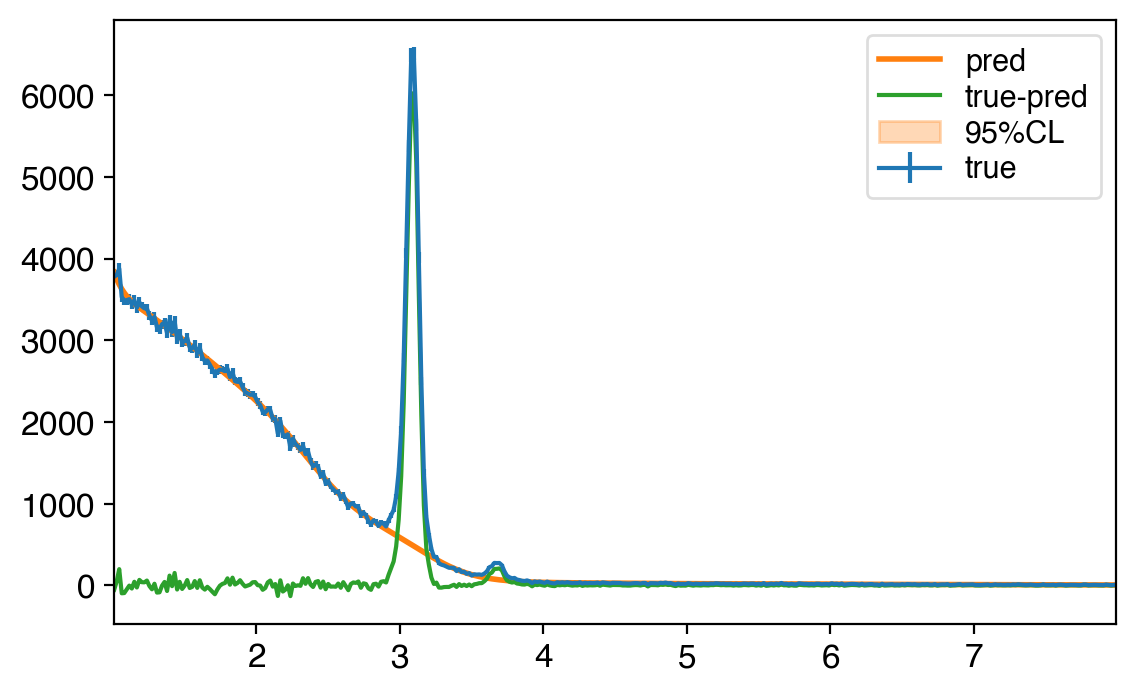

In [8]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

h = Hist1D(df_data.query("1<dimuon_mass<8")["dimuon_mass"],bins=np.linspace(1,8,400))
# h *= 1./float(h.counts.sum())

xflat = h.bin_centers
mask = ~(
    ((xflat > 2.6) & (xflat < 3.4)) | ((xflat > 3.5) & (xflat < 3.9))
)

do_log_transform = True
X = xflat[mask][:,np.newaxis]
y = h.counts[mask]
if do_log_transform:
    y = np.log(y)
# dy = h.errors[mask]

gp = GaussianProcessRegressor()

gp.fit(X, y)

fig,ax = plt.subplots()
ypred,sigma = gp.predict(h.bin_centers[:,np.newaxis], return_std=True)
sigma *= 1.95
relerr = sigma/ypred
if do_log_transform:
    ypred = np.exp(ypred)
sigma = ypred*relerr
# ax.plot(h.bin_centers,h.counts,label="true")
ax.errorbar(h.bin_centers,h.counts,yerr=h.errors,label="true",lw=1.5)
# h.plot(label="true",lw=1.0)
# ax.errorbar(h.bin_centers,ypred,yerr=sigma,label="pred")
ax.plot(h.bin_centers,ypred,label="pred",lw=2)
# ax.errorbar(h.bin_centers,ypred,yerr=h.errors,label="pred")
ax.fill_between(h.bin_centers,y1=ypred+sigma,y2=ypred-sigma,label="95%CL",alpha=0.3,color="C1")
ax.plot(h.bin_centers,h.counts-ypred,label="true-pred")
ax.legend()
# ax.set_yscale("log")
# ax.set_ylim([0.,ax.get_ylim()[1]])